In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')
df_tilt_data = pd.read_pickle("/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/df_tilt_data.pkl")
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
# import sys
# sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
# from utils import plot_ellipse, smooth, tilt_distance_LI, compute_tilt_data, bearing


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [3]:
sample_eddies = [66, 425, 871, 1780, 31, 182, 1602, 2128]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]
    

In [4]:
mask = np.abs(z_r) < 1000
depth = np.abs(z_r[mask])
n = depth.size

base = pd.DataFrame({"Depth": depth})
frames = []

for eddy, dic in dic_sample.items():
    for d, (df, day) in enumerate(zip(dic.values(), dic.keys())):
        if df.empty:
            continue
        day = int(day[3:])
        df2 = df.loc[df["Depth"].abs() < 1000, ["x", "y"]].reset_index(drop=True)
        tmp = df2.reindex(range(n))  # pad with NaNs to match depth levels
        tmp.columns = [f"{eddy}_Day{day}_x", f"{eddy}_Day{day}_y"]
        frames.append(tmp)

df_depths = pd.concat([base, *frames], axis=1, copy=False)
df_depths


,Depth,Eddy66_Day1674_x,Eddy66_Day1674_y,Eddy66_Day1675_x,Eddy66_Day1675_y,Eddy66_Day1676_x,Eddy66_Day1676_y,Eddy66_Day1679_x,Eddy66_Day1679_y,Eddy66_Day1680_x,...,Eddy2128_Day8966_x,Eddy2128_Day8966_y,Eddy2128_Day8967_x,Eddy2128_Day8967_y,Eddy2128_Day8968_x,Eddy2128_Day8968_y,Eddy2128_Day8969_x,Eddy2128_Day8969_y,Eddy2128_Day8970_x,Eddy2128_Day8970_y
0,1.783320,838.082945,1463.359042,841.944207,1458.453989,845.647270,1457.132245,844.231507,1488.502854,839.416705,...,253.084486,567.480090,241.881085,536.699813,238.604963,523.279677,240.586005,517.400123,242.627058,498.439709
1,5.879627,838.449025,1462.889245,842.548504,1458.370782,846.492748,1457.401894,844.139211,1487.952266,839.914092,...,247.609623,560.154560,240.715586,532.490102,238.290099,522.534501,239.280399,516.258631,243.434436,499.768934
2,10.725783,838.490020,1462.700349,842.953076,1458.517750,846.865130,1457.608137,844.148262,1487.665062,840.245640,...,246.281557,545.042801,240.745331,532.123683,238.367262,522.731495,239.246365,516.226479,243.800521,500.998354
3,16.383097,838.643865,1462.945791,843.346376,1458.755273,847.123878,1457.839066,844.146417,1487.423538,840.456378,...,243.799958,535.565244,240.616023,531.272790,238.396574,522.900646,239.201841,516.231714,243.843124,502.265386
4,22.925581,838.758631,1462.524487,843.581149,1458.630220,847.346424,1458.110049,844.146634,1487.093842,840.741524,...,243.910670,532.647053,240.598377,530.937821,238.286392,522.686191,239.195147,516.253579,243.571661,503.336370
5,30.444118,838.899192,1462.704843,843.973783,1459.065805,848.195131,1460.480151,844.096139,1486.861545,840.803457,...,243.769833,530.865328,240.644250,530.863947,238.164996,522.375225,239.006638,516.161120,243.011629,503.642985
6,39.052712,839.117184,1462.531297,844.352940,1459.700432,848.259160,1462.114486,844.007418,1486.672237,840.963613,...,243.670698,529.715716,240.596766,530.618297,238.173968,522.198867,238.825620,516.215450,242.030140,503.900624
7,48.897638,839.480305,1462.474008,844.380259,1461.188048,848.335503,1462.858759,843.788228,1486.529163,841.421390,...,243.619169,529.028098,240.506829,530.299263,238.209823,522.420784,238.481207,516.020812,241.513391,503.474732
8,60.170639,840.037014,1462.728148,844.866533,1462.552153,848.400615,1465.279241,843.360048,1486.256158,841.036146,...,243.535369,528.354243,240.444449,530.076358,238.148097,522.564441,238.168532,515.534681,241.119982,502.661505
9,73.127842,841.301853,1463.629237,845.664766,1464.587517,848.068300,1469.311099,842.087392,1485.073831,842.182898,...,243.429020,527.584898,240.481575,530.022219,237.992685,522.612111,238.053530,515.256108,240.797998,502.139416


### Buoyancy Frequency

In [5]:
def add_center_N2_columns(
    df_depths,
    df_eddies,
    X_grid,
    Y_grid,
    mask_rho,
    z_r,
    base_path,
    varname="N2",
    depth_max=1000,
):
    z1d = np.abs(z_r)
    maskz = z1d < depth_max
    depth = z1d[maskz]
    iz = np.flatnonzero(maskz)
    n = iz.size

    X = np.asarray(X_grid)
    Y = np.asarray(Y_grid)
    wet = np.asarray(mask_rho).astype(bool)

    Xf = X[wet].ravel()
    Yf = Y[wet].ravel()
    wet_idx = np.flatnonzero(wet)
    shp = X.shape

    try:
        from scipy.spatial import cKDTree
        tree = cKDTree(np.c_[Xf, Yf])
        def nearest_ij(xc, yc):
            _, k = tree.query([xc, yc])
            return np.unravel_index(wet_idx[k], shp)
    except Exception:
        def nearest_ij(xc, yc):
            d2 = (Xf - xc) ** 2 + (Yf - yc) ** 2
            k = int(np.nanargmin(d2))
            return np.unravel_index(wet_idx[k], shp)

    valid_pairs = set(
        df_eddies.loc[~df_eddies["TiltDis"].isna(), ["Eddy", "Day"]]
        .itertuples(index=False, name=None)
    )

    key2fname = (
        df_eddies[["Eddy", "Day", "fname"]]
        .dropna(subset=["fname"])
        .drop_duplicates(["Eddy", "Day"])
        .set_index(["Eddy", "Day"])["fname"]
    )

    cols = {}
    N2_cache = {}

    for col in df_depths.columns:
        if not col.endswith("_x"):
            continue

        base = col[:-2]
        ycol = base + "_y"
        outcol = base + "_N2"

        try:
            eddy = int(base.split("_Day")[0].replace("Eddy", ""))
            day  = int(base.split("_Day")[1])
        except Exception:
            continue

        # ---- HARD SKIP: no TiltDis → no column ----
        if (eddy, day) not in valid_pairs:
            continue

        if (eddy, day) not in key2fname.index:
            continue

        fname = str(key2fname.loc[(eddy, day)])
        fnumber = int(fname[-8:-3])
        base_day = fnumber + 1
        t_idx = int(day - base_day)

        if fnumber not in N2_cache:
            N2 = np.load(f"{base_path}/{varname}_{fnumber:05}.npy")  # (x,y,z,t)
            N2 = np.where(wet[:, :, None, None], N2, np.nan)
            N2_cache[fnumber] = N2
        else:
            N2 = N2_cache[fnumber]

        if t_idx < 0 or t_idx >= N2.shape[3]:
            continue

        vals = np.full(n, np.nan)

        xs = df_depths[col].to_numpy()
        ys = df_depths[ycol].to_numpy()

        kk = np.flatnonzero(np.isfinite(xs) & np.isfinite(ys))
        for k in kk:
            ic, jc = nearest_ij(xs[k], ys[k])
            vals[k] = N2[ic, jc, iz[k], t_idx]

        cols[outcol] = vals

    df_N2s = pd.concat(
        [pd.DataFrame({"Depth": depth}), pd.DataFrame(cols)],
        axis=1
    )
    return df_N2s



In [6]:
df_N2s = add_center_N2_columns(
    df_depths=df_depths,
    df_eddies=df_eddies,
    X_grid=X_grid,
    Y_grid=Y_grid,
    mask_rho=mask_rho,
    z_r=z_r,
    base_path="/srv/scratch/z5297792/Climatology/N2s/N2s",
    varname="N2",
    depth_max=1000,
)


In [7]:
df_N2s


,Depth,Eddy66_Day1679_N2,Eddy66_Day1680_N2,Eddy66_Day1681_N2,Eddy66_Day1682_N2,Eddy66_Day1683_N2,Eddy66_Day1684_N2,Eddy66_Day1691_N2,Eddy66_Day1692_N2,Eddy66_Day1693_N2,...,Eddy2128_Day8957_N2,Eddy2128_Day8958_N2,Eddy2128_Day8959_N2,Eddy2128_Day8960_N2,Eddy2128_Day8961_N2,Eddy2128_Day8962_N2,Eddy2128_Day8963_N2,Eddy2128_Day8964_N2,Eddy2128_Day8966_N2,Eddy2128_Day8967_N2
0,1.783320,0.000036,0.000038,0.000034,0.000035,0.000035,0.000036,0.000049,0.000037,0.000040,...,0.000037,0.000037,0.000037,0.000040,0.000041,0.000043,0.000037,0.000037,0.000041,0.000056
1,5.879627,0.000040,0.000040,0.000039,0.000039,0.000039,0.000039,0.000040,0.000040,0.000042,...,0.000040,0.000040,0.000040,0.000041,0.000042,0.000043,0.000040,0.000040,0.000041,0.000045
2,10.725783,0.000040,0.000041,0.000040,0.000040,0.000040,0.000040,0.000041,0.000041,0.000042,...,0.000041,0.000041,0.000041,0.000041,0.000042,0.000043,0.000041,0.000041,0.000045,0.000042
3,16.383097,0.000041,0.000041,0.000040,0.000040,0.000040,0.000041,0.000041,0.000041,0.000042,...,0.000041,0.000041,0.000041,0.000042,0.000042,0.000043,0.000041,0.000041,0.000042,0.000042
4,22.925581,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000042,0.000041,0.000042,...,0.000041,0.000041,0.000041,0.000042,0.000042,0.000044,0.000042,0.000041,0.000043,0.000042
5,30.444118,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000042,0.000041,0.000042,...,0.000042,0.000041,0.000042,0.000042,0.000042,0.000044,0.000042,0.000041,0.000042,0.000042
6,39.052712,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000042,0.000041,0.000042,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000043,0.000042,0.000042,0.000043,0.000042
7,48.897638,0.000041,0.000042,0.000041,0.000041,0.000041,0.000041,0.000042,0.000041,0.000042,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042
8,60.170639,0.000042,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042
9,73.127842,0.000043,0.000042,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,0.000041,...,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042,0.000042


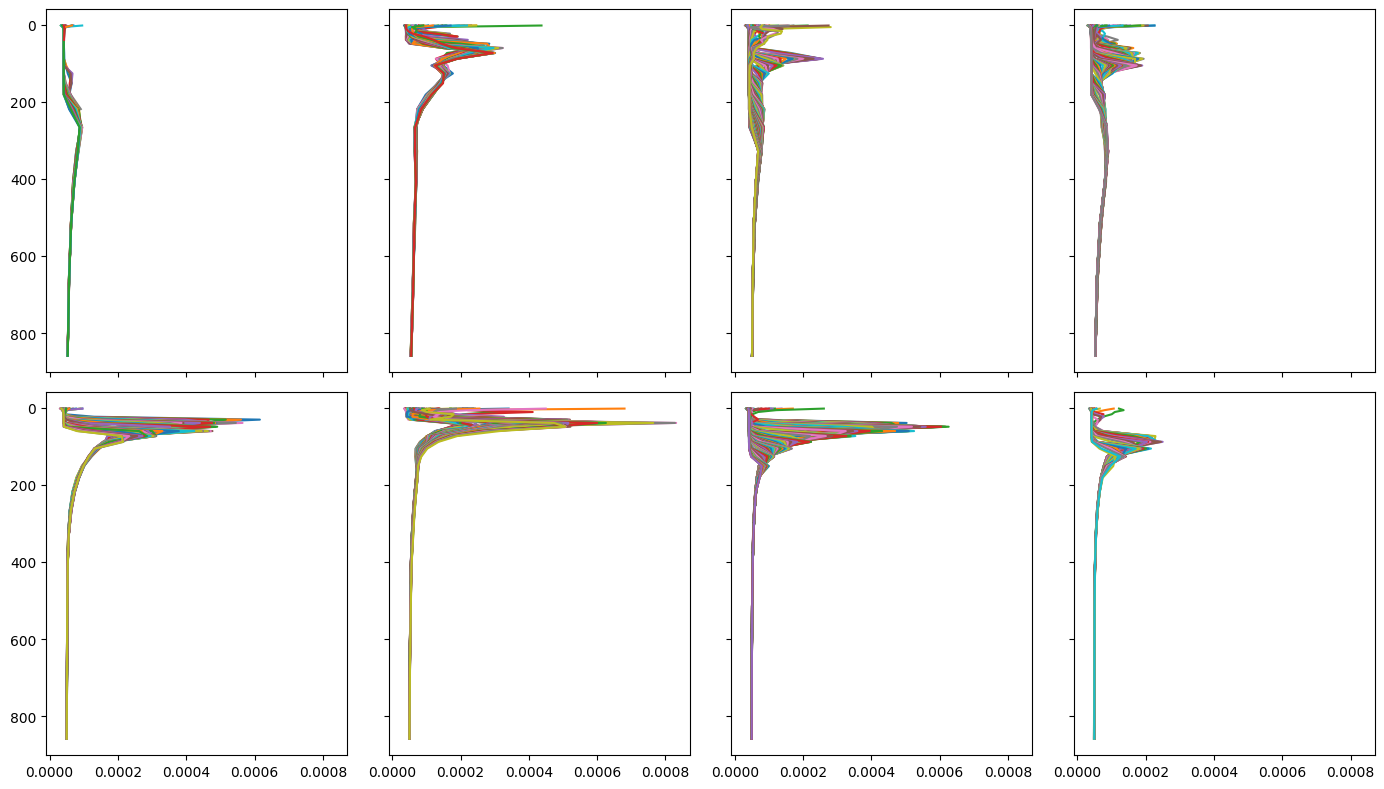

In [8]:
fig, axs = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(14,8))
axs = axs.flatten()
for k, n2col in enumerate(df_N2s.columns):
    if k !=0:
        eddy_id = int(n2col.split("_")[0].replace("Eddy", ""))
        p = np.where([eddy_id==i for i in sample_eddies])[0][0]
        if n2col.endswith("_N2"):
            axs[p].plot(df_N2s[f'{n2col}'], df_N2s.Depth)
axs[0].invert_yaxis()
plt.tight_layout()


### Translation Speed

In [9]:
import re
def fill_missing_eddy_days(df_depths):
    cols = list(df_depths.columns)

    out_parts = [df_depths[["Depth"]]]

    pat = re.compile(r"Eddy(\d+)_Day(\d+)_(x|y)")

    # extract eddy/day info in ORIGINAL column order
    parsed = []
    for c in cols:
        m = pat.match(c)
        if m:
            eddy, day, coord = int(m.group(1)), int(m.group(2)), m.group(3)
            parsed.append((eddy, day, coord, c))

    dfp = pd.DataFrame(parsed, columns=["Eddy", "Day", "coord", "col"])

    # eddy order = first appearance in original df
    eddy_order = (
        dfp.drop_duplicates("Eddy", keep="first")
           .sort_index()
           ["Eddy"]
           .tolist()
    )

    for eddy in eddy_order:
        g = dfp[dfp["Eddy"] == eddy]
        days = np.arange(g["Day"].min(), g["Day"].max() + 1)

        for day in days:
            for coord in ("x", "y"):
                cname = f"Eddy{eddy}_Day{day}_{coord}"
                if cname in df_depths.columns:
                    out_parts.append(df_depths[[cname]])
                else:
                    out_parts.append(
                        pd.DataFrame({cname: np.nan}, index=df_depths.index)
                    )

    return pd.concat(out_parts, axis=1)
df_depths_filled = fill_missing_eddy_days(df_depths)
df_depths_filled


,Depth,Eddy66_Day1674_x,Eddy66_Day1674_y,Eddy66_Day1675_x,Eddy66_Day1675_y,Eddy66_Day1676_x,Eddy66_Day1676_y,Eddy66_Day1677_x,Eddy66_Day1677_y,Eddy66_Day1678_x,...,Eddy2128_Day8966_x,Eddy2128_Day8966_y,Eddy2128_Day8967_x,Eddy2128_Day8967_y,Eddy2128_Day8968_x,Eddy2128_Day8968_y,Eddy2128_Day8969_x,Eddy2128_Day8969_y,Eddy2128_Day8970_x,Eddy2128_Day8970_y
0,1.783320,838.082945,1463.359042,841.944207,1458.453989,845.647270,1457.132245,NaN,NaN,NaN,...,253.084486,567.480090,241.881085,536.699813,238.604963,523.279677,240.586005,517.400123,242.627058,498.439709
1,5.879627,838.449025,1462.889245,842.548504,1458.370782,846.492748,1457.401894,NaN,NaN,NaN,...,247.609623,560.154560,240.715586,532.490102,238.290099,522.534501,239.280399,516.258631,243.434436,499.768934
2,10.725783,838.490020,1462.700349,842.953076,1458.517750,846.865130,1457.608137,NaN,NaN,NaN,...,246.281557,545.042801,240.745331,532.123683,238.367262,522.731495,239.246365,516.226479,243.800521,500.998354
3,16.383097,838.643865,1462.945791,843.346376,1458.755273,847.123878,1457.839066,NaN,NaN,NaN,...,243.799958,535.565244,240.616023,531.272790,238.396574,522.900646,239.201841,516.231714,243.843124,502.265386
4,22.925581,838.758631,1462.524487,843.581149,1458.630220,847.346424,1458.110049,NaN,NaN,NaN,...,243.910670,532.647053,240.598377,530.937821,238.286392,522.686191,239.195147,516.253579,243.571661,503.336370
5,30.444118,838.899192,1462.704843,843.973783,1459.065805,848.195131,1460.480151,NaN,NaN,NaN,...,243.769833,530.865328,240.644250,530.863947,238.164996,522.375225,239.006638,516.161120,243.011629,503.642985
6,39.052712,839.117184,1462.531297,844.352940,1459.700432,848.259160,1462.114486,NaN,NaN,NaN,...,243.670698,529.715716,240.596766,530.618297,238.173968,522.198867,238.825620,516.215450,242.030140,503.900624
7,48.897638,839.480305,1462.474008,844.380259,1461.188048,848.335503,1462.858759,NaN,NaN,NaN,...,243.619169,529.028098,240.506829,530.299263,238.209823,522.420784,238.481207,516.020812,241.513391,503.474732
8,60.170639,840.037014,1462.728148,844.866533,1462.552153,848.400615,1465.279241,NaN,NaN,NaN,...,243.535369,528.354243,240.444449,530.076358,238.148097,522.564441,238.168532,515.534681,241.119982,502.661505
9,73.127842,841.301853,1463.629237,845.664766,1464.587517,848.068300,1469.311099,NaN,NaN,NaN,...,243.429020,527.584898,240.481575,530.022219,237.992685,522.612111,238.053530,515.256108,240.797998,502.139416


In [10]:
def compute_dxdy(df_depths_filled):
    out_parts = [df_depths_filled[["Depth"]]]

    pat = re.compile(r"Eddy(\d+)_Day(\d+)_(x|y)")
    parsed = []

    for c in df_depths_filled.columns:
        m = pat.match(c)
        if m:
            eddy, day, coord = int(m.group(1)), int(m.group(2)), m.group(3)
            parsed.append((eddy, day, coord, c))

    dfp = pd.DataFrame(parsed, columns=["Eddy", "Day", "coord", "col"])

    # preserve eddy order
    eddy_order = (
        dfp.drop_duplicates("Eddy", keep="first")
           .sort_index()
           ["Eddy"]
           .tolist()
    )

    for eddy in eddy_order:
        g = dfp[dfp["Eddy"] == eddy]

        days = np.sort(g["Day"].unique())

        for d0, d1 in zip(days[:-1], days[1:]):
            if d1 != d0 + 1:
                continue  # skip gaps

            x0 = f"Eddy{eddy}_Day{d0}_x"
            x1 = f"Eddy{eddy}_Day{d1}_x"
            y0 = f"Eddy{eddy}_Day{d0}_y"
            y1 = f"Eddy{eddy}_Day{d1}_y"

            if not all(c in df_depths_filled.columns for c in (x0, x1, y0, y1)):
                continue

            dx = df_depths_filled[x1] - df_depths_filled[x0]
            dy = df_depths_filled[y1] - df_depths_filled[y0]

            # drop if completely NaN
            if dx.notna().any():
                out_parts.append(
                    dx.rename(f"Eddy{eddy}_Day{d1}_dx")
                )

            if dy.notna().any():
                out_parts.append(
                    dy.rename(f"Eddy{eddy}_Day{d1}_dy")
                )

    return pd.concat(out_parts, axis=1)
df_dxdy = compute_dxdy(df_depths_filled)
df_dxdy 



,Depth,Eddy66_Day1675_dx,Eddy66_Day1675_dy,Eddy66_Day1676_dx,Eddy66_Day1676_dy,Eddy66_Day1680_dx,Eddy66_Day1680_dy,Eddy66_Day1681_dx,Eddy66_Day1681_dy,Eddy66_Day1682_dx,...,Eddy2128_Day8964_dx,Eddy2128_Day8964_dy,Eddy2128_Day8967_dx,Eddy2128_Day8967_dy,Eddy2128_Day8968_dx,Eddy2128_Day8968_dy,Eddy2128_Day8969_dx,Eddy2128_Day8969_dy,Eddy2128_Day8970_dx,Eddy2128_Day8970_dy
0,1.783320,3.861262,-4.905053,3.703062,-1.321744,-4.814802,3.439400,-3.320031,-8.685215,1.077479,...,1.890593,0.967940,-11.203401,-30.780276,-3.276122,-13.420136,1.981042,-5.879554,2.041053,-18.960414
1,5.879627,4.099479,-4.518463,3.944244,-0.968888,-4.225118,2.131795,-1.863334,-8.426849,-0.318507,...,-0.206373,1.002147,-6.894037,-27.664458,-2.425487,-9.955602,0.990300,-6.275870,4.154037,-16.489696
2,10.725783,4.463056,-4.182599,3.912054,-0.909613,-3.902622,1.433159,-0.653195,-8.354665,-1.622034,...,-1.154938,0.745493,-5.536226,-12.919117,-2.378069,-9.392189,0.879103,-6.505015,4.554156,-15.228125
3,16.383097,4.702510,-4.190518,3.777502,-0.916206,-3.690040,0.926843,-0.359501,-7.369232,-1.966663,...,-1.860404,0.607751,-3.183935,-4.292454,-2.219449,-8.372144,0.805267,-6.668932,4.641283,-13.966329
4,22.925581,4.822518,-3.894266,3.765275,-0.520171,-3.405110,0.483622,-0.235312,-6.921487,-1.676433,...,-3.255789,0.310093,-3.312292,-1.709231,-2.311986,-8.251630,0.908755,-6.432612,4.376514,-12.917209
5,30.444118,5.074590,-3.639037,4.221348,1.414345,-3.292682,0.962525,0.294399,-7.824342,-2.167551,...,-3.703504,0.196520,-3.125583,-0.001380,-2.479254,-8.488722,0.841642,-6.214104,4.004991,-12.518135
6,39.052712,5.235756,-2.830864,3.906220,2.414054,-3.043805,0.535342,0.403014,-7.451197,-2.355731,...,-3.838511,-0.058186,-3.073931,0.902581,-2.422798,-8.419430,0.651652,-5.983418,3.204520,-12.314826
7,48.897638,4.899954,-1.285960,3.955243,1.670712,-2.366838,-0.931246,-0.088869,-5.312890,-2.066953,...,-4.190970,-0.134445,-3.112340,1.271166,-2.297006,-7.878480,0.271384,-6.399971,3.032184,-12.546080
8,60.170639,4.829519,-0.175995,3.534082,2.727089,-2.323903,-1.000990,0.719929,-5.976379,-2.351436,...,-4.540095,-0.210278,-3.090920,1.722115,-2.296352,-7.511917,0.020435,-7.029760,2.951451,-12.873177
9,73.127842,4.362914,0.958280,2.403534,4.723582,0.095506,-1.422264,-0.765903,-4.233618,-1.849796,...,-4.911411,-0.277430,-2.947444,2.437321,-2.488890,-7.410108,0.060844,-7.356003,2.744468,-13.116692


In [11]:
def build_magN2_df(df_N2s, df_dxdy):
    out_parts = [df_N2s[["Depth"]].copy()]

    for n2col in df_N2s.columns:
        if not n2col.endswith("_N2"):
            continue

        base = n2col[:-3]                  # EddyXX_DayYY
        dxcol = base + "_dx"
        dycol = base + "_dy"
        magcol = base + "_dxdymag"

        # must have both dx and dy
        if dxcol not in df_dxdy.columns or dycol not in df_dxdy.columns:
            continue

        mag = np.hypot(df_dxdy[dxcol].to_numpy(),
                        df_dxdy[dycol].to_numpy())

        # --- HARD DROP if all NaN ---
        if not np.isfinite(mag).any():
            continue

        out_parts.append(
            pd.DataFrame(
                {
                    magcol: mag,
                    n2col: df_N2s[n2col].to_numpy(),
                },
                index=df_N2s.index,
            )
        )

    return pd.concat(out_parts, axis=1, copy=False)

df_magN2 = build_magN2_df(df_N2s, df_dxdy)
df_magN2


,Depth,Eddy66_Day1680_dxdymag,Eddy66_Day1680_N2,Eddy66_Day1681_dxdymag,Eddy66_Day1681_N2,Eddy66_Day1682_dxdymag,Eddy66_Day1682_N2,Eddy66_Day1683_dxdymag,Eddy66_Day1683_N2,Eddy66_Day1684_dxdymag,...,Eddy2128_Day8961_dxdymag,Eddy2128_Day8961_N2,Eddy2128_Day8962_dxdymag,Eddy2128_Day8962_N2,Eddy2128_Day8963_dxdymag,Eddy2128_Day8963_N2,Eddy2128_Day8964_dxdymag,Eddy2128_Day8964_N2,Eddy2128_Day8967_dxdymag,Eddy2128_Day8967_N2
0,1.783320,5.917076,0.000038,9.298149,0.000034,5.289021,0.000035,6.906035,0.000035,4.226690,...,17.070070,0.000041,11.952916,0.000043,9.659387,0.000037,2.123970,0.000037,32.755787,0.000056
1,5.879627,4.732460,0.000040,8.630399,0.000039,3.003144,0.000039,5.577244,0.000039,2.643471,...,13.240073,0.000042,9.674331,0.000043,9.776290,0.000040,1.023175,0.000040,28.510524,0.000045
2,10.725783,4.157451,0.000041,8.380161,0.000040,2.426586,0.000040,4.968940,0.000040,3.712637,...,11.322444,0.000042,8.312739,0.000043,9.982172,0.000041,1.374642,0.000041,14.055369,0.000042
3,16.383097,3.804659,0.000041,7.377996,0.000040,2.715670,0.000040,4.729355,0.000040,3.787970,...,9.912781,0.000042,7.337409,0.000043,10.505984,0.000041,1.957157,0.000041,5.344399,0.000042
4,22.925581,3.439282,0.000041,6.925486,0.000041,2.337487,0.000041,4.514427,0.000041,3.844818,...,8.671253,0.000042,6.809144,0.000044,10.259692,0.000042,3.270522,0.000041,3.727298,0.000042
5,30.444118,3.430482,0.000041,7.829878,0.000041,2.316158,0.000041,4.407333,0.000041,3.474515,...,7.639582,0.000042,7.126145,0.000044,10.178938,0.000042,3.708714,0.000041,3.125583,0.000042
6,39.052712,3.090524,0.000041,7.462088,0.000041,2.395633,0.000041,4.663355,0.000041,3.514008,...,7.274055,0.000042,8.190795,0.000043,9.256964,0.000042,3.838952,0.000042,3.203702,0.000042
7,48.897638,2.543450,0.000042,5.313633,0.000041,2.639048,0.000041,4.159343,0.000041,3.658184,...,7.025765,0.000042,8.883415,0.000042,8.576306,0.000042,4.193126,0.000042,3.361922,0.000042
8,60.170639,2.530317,0.000041,6.019585,0.000041,2.449341,0.000041,4.094318,0.000041,3.772422,...,6.844650,0.000042,9.269581,0.000042,8.286353,0.000042,4.544962,0.000042,3.538286,0.000042
9,73.127842,1.425467,0.000042,4.302340,0.000041,2.073030,0.000041,3.577903,0.000041,4.006867,...,6.706423,0.000042,9.486694,0.000042,8.212955,0.000042,4.919240,0.000042,3.824652,0.000042


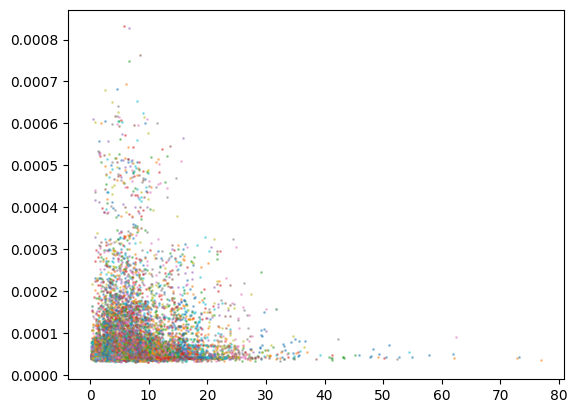

In [12]:
for col in df_magN2.columns:
    if not col.endswith("_N2"):
        continue

    base = col[:-3]  # EddyXX_DayYY
    mag = df_magN2[base + "_dxdymag"]
    N2  = df_magN2[col]

    # drop NaNs so scatter doesn’t complain
    m = mag.notna() & N2.notna()

    if not m.any():
        continue

    plt.scatter(mag[m], N2[m], s=1, alpha=0.4)
    

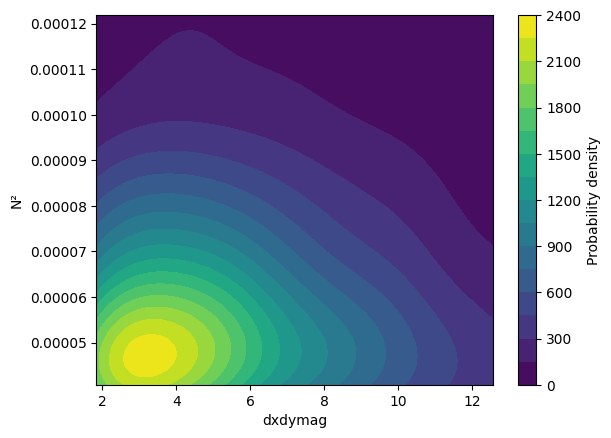

In [13]:
from scipy.stats import gaussian_kde

# collect all data
mag_all, N2_all = [], []

for col in df_magN2.columns:
    if col.endswith("_N2"):
        base = col[:-3]
        mag_all.append(df_magN2[base + "_dxdymag"])
        N2_all.append(df_magN2[col])

mag = pd.concat(mag_all).to_numpy()
N2  = pd.concat(N2_all).to_numpy()

m = np.isfinite(mag) & np.isfinite(N2)
mag, N2 = mag[m], N2[m]

# KDE
values = np.vstack([mag, N2])
kde = gaussian_kde(values)

# grid
# x = np.linspace(mag.min(), mag.max(), 200)
# y = np.linspace(N2.min(), N2.max(), 200)
x = np.linspace(*np.nanpercentile(mag, [10, 90]), 200)
y = np.linspace(*np.nanpercentile(N2, [10, 90]), 200)
X, Y = np.meshgrid(x, y)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

plt.contourf(X, Y, Z, levels=20)
plt.xlabel("dxdymag")
plt.ylabel("N²")
plt.colorbar(label="Probability density")


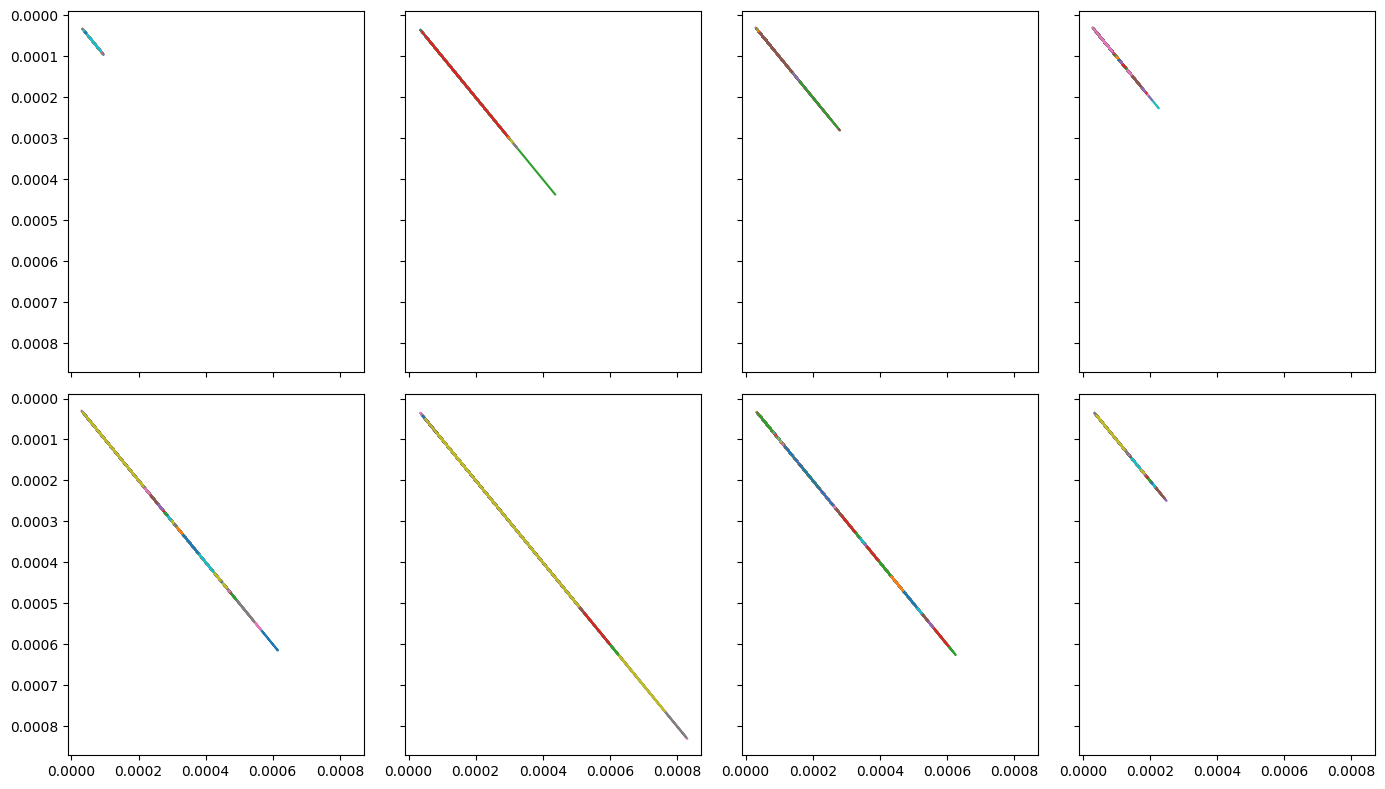

In [14]:
fig, axs = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(14,8))
axs = axs.flatten()
for k, n2col in enumerate(df_magN2.columns):
    if k !=0:
        eddy_id = int(n2col.split("_")[0].replace("Eddy", ""))
        p = np.where([eddy_id==i for i in sample_eddies])[0][0]
        if n2col.endswith("_N2"):
            axs[p].plot(df_magN2[f'{n2col}'], df_magN2[f'{n2col}'])
axs[0].invert_yaxis()
plt.tight_layout()


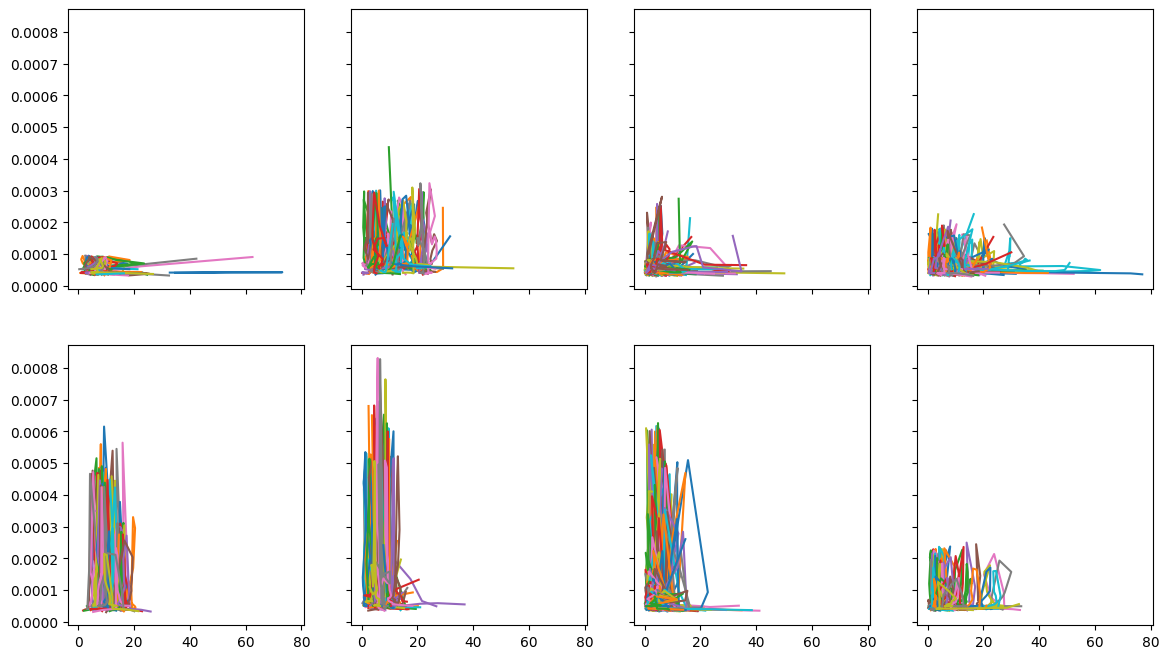

In [15]:
fig, axs = plt.subplots(2, 4, sharey=True, sharex=True, figsize=(14,8))
axs = axs.flatten()
for col in df_magN2.columns:
    if not col.endswith("_N2"):
        continue

    base = col[:-3]  # EddyXX_DayYY
    mag = df_magN2[base + "_dxdymag"]
    N2  = df_magN2[col]
    eddy_id = int(col.split("_")[0].replace("Eddy", ""))
    p = np.where([eddy_id==i for i in sample_eddies])[0][0]
    axs[p].plot(mag, N2)
    